## Argo Multiple Regions Test

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
#from argopy import DataFetcher as ArgoDataFetcher
#argo_loader = ArgoDataFetcher(parallel=True)
import scipy.ndimage as filter
filter.gaussian_filter1d
import cartopy.crs as ccrs
import cartopy

In [37]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader=ArgoDataFetcher(src='gdac',ftp="/swot/SUM05/dbalwada/202206-ArgoData",parallel=True)

In [36]:
ds = argo_loader.region([30,40,-55,-50,0,2000]).to_xarray()

/home.ufs/amf2288/.conda/envs/argo/lib/python3.10/site-packages/argopy/data_fetchers/gdacftp_data.py:330: UserWarning: Found more than 50 files to load, this may take a while to process sequentially ! Consider using another data source (eg: 'erddap') or the 'parallel=True' option to improve processing time.
  warnings.warn(


In [39]:
ds.argo.point2profile()

<xarray.Dataset>
Dimensions:                (N_PROF: 129, N_LEVELS: 1004)
Coordinates:
  * N_PROF                 (N_PROF) int64 10 0 11 1 12 2 ... 127 128 119 120 121
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1000 1001 1002 1003
    TIME                   (N_PROF) datetime64[ns] 2004-05-04T06:20:20 ... 20...
    LATITUDE               (N_PROF) float64 -51.27 -50.53 ... -50.34 -50.72
    LONGITUDE              (N_PROF) float64 35.22 33.78 34.87 ... 37.57 30.19
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 5 5 6
    CYCLE_NUMBER           (N_PROF) int32 1 1 2 2 3 3 ... 324 325 155 158 227
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1900192 1900191 ... 1901599 1901626
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 2 1 2 1 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float64 33.83 33.83 ... nan nan
    PSAL_QC                (N_PROF) int32 2 1 2 1 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float64 2.838 2.85 ... nan nan
    TEMP_QC                (N_PROF) int32 2 1 2 1 2 2 2 2 2 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/202206-ArgoData
    Fetched_by:           amf2288
    Fetched_date:         2022/07/18
    Fetched_constraints:  [x=30.00/40.00; y=-55.00/-50.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/202206-ArgoData/dac/coriolis/6...
    history:              Variables filtered according to DATA_MODE; Variable...

## Useful Functions

In [ ]:
#NOTE: choosing higer depth_max values will limit the number of profiles returned
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [ ]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [ ]:
def get_var(ds_interp,ds_filt):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp).var()
    return var

In [ ]:
def get_2_depths(ds,first,mid,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [ ]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Define Regions

In [3]:
#Southern Ocean, south of Africa
so_param=[30,40,-55,-50,0,2000]
#so_ds=argo_loader.region(so_param).to_xarray()
#so_ds=so_ds.argo.point2profile()

In [4]:
#North Pacific
np_param=[-155,-145,35,40,0,2000]
#np_ds=argo_loader.region(np_param).to_xarray()
#np_ds=np_ds.argo.point2profile()

In [5]:
#North Atlantic
na_param=[-35,-25,40,45,0,2000]
#na_ds=argo_loader.region(na_param).to_xarray()
#na_ds=na_ds.argo.point2profile()

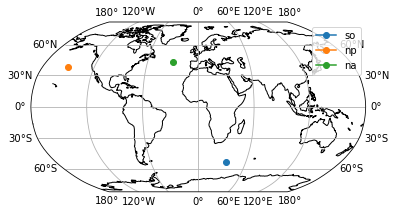

In [22]:
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np.average(so_param[0:2]), np.average(so_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='so')
plt.plot(np.average(np_param[0:2]), np.average(np_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='np')
plt.plot(np.average(na_param[0:2]), np.average(na_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='na')
plt.legend()

In [ ]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)

In [ ]:
so_filt=get_ds_filt(so_interp,0.5,2.5.50)
np_filt=get_ds_filt(np_interp,0.5,2.5.50)
na_filt=get_ds_filt(na_interp,0.5,2.5.50)

In [ ]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(1/so_filt.FILT_SCALE,so_var,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/so_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1
plt.plot(x,y_2)
plt.plot(x,y_1)

plt.subplot(1,3,2)
plt.plot(1/np_filt.FILT_SCALE,np_var,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/np_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1
plt.plot(x,y_2)
plt.plot(x,y_1)

plt.subplot(1,3,3)
plt.plot(1/na_filt.FILT_SCALE,na_var,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/na_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1
plt.plot(x,y_2)
plt.plot(x,y_1)

## Filtering at Different Depths